## Model and Error Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import datetime as dt
import warnings
import pickle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import (confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)

%config InlineBackend.figure_format = 'retina'
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [149]:
#Importing model and datasets for analysis

final_lr_model = pickle.load(open('./models/final_lr_model.sav', 'rb'))

final_train_df = pd.read_csv('../data/final_train.csv')

weather_train_df = pd.read_csv('../data/weather_train_merged.csv')

model_test_data = pd.read_csv('../data/model_test_data.csv')

In [215]:
# fitting model to get predictions for model and error analysis

x = final_train_df.drop('wnvpresent',axis=1)
y = final_train_df['wnvpresent']

display(y.value_counts(normalize=True))

x_train, x_test, y_train, y_test= train_test_split(x,y,random_state=42)

ss = StandardScaler()

x_train_sc = ss.fit_transform(x_train)

x_test_sc = ss.transform(x_test)

sm = SMOTE(random_state=42)

x_train_sc, y_train = sm.fit_resample(x_train_sc,y_train)

final_lr_model.fit(x_train_sc,y_train)

predictions = final_lr_model.predict(x_test_sc)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,coefficients
dewpoint*tavg_minus_2w,1.751891
nummosquitos*week,0.964966
week*dewpoint_minus_2w,0.913410
trap_T900,0.847108
tavg_minus_2w*dewpoint_minus_2w,0.760545
weekday_4,0.741605
week*tavg,0.733868
month_8,0.731020
weekday_5,0.623461
weekday_3,0.595266


Text(0.5, 1.0, 'Top 10 Correlated Features')

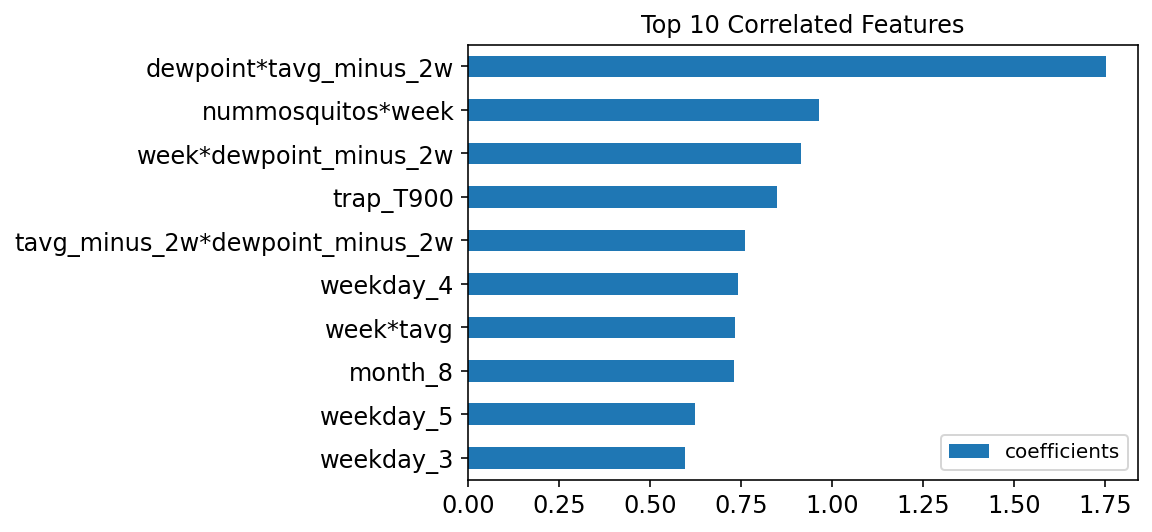

In [350]:
# Filtering out top coefficients for wnv predictions

log_coef = pd.DataFrame(final_lr_model.best_estimator_.steps[0][1].coef_.T,x_test.columns,
                        columns = ['coefficients']).sort_values(by='coefficients', ascending=False)

display(log_coef.head(10))

log_coef.head(10).sort_values(by = 'coefficients',ascending=True).plot(kind='barh')

plt.title('Top 10 Correlated Features')

We can see that dewpoint, temperature, number of mosquitos, time and traps are strong predictors of WNV. Hence, we will inspect our misclassifications with these features to see if they are inline with what we expect.

In [241]:
# Filtering out weekday counts for july-september

weather_train_df[(weather_train_df['month']==7)|\
                 (weather_train_df['month']==8)|\
                 (weather_train_df['month']==9)]['weekday'].value_counts()

5    2640
4    1924
3    1425
1    1147
2     711
Name: weekday, dtype: int64

We can see that for the months of Jul-Sep where there is high WNV, there were much more samples collected from wednesday to friday. Hence, it is natural that wed-fri were seen as good predictors for WNV as there were simply more cases collected. It is thus recommended to either ensure that collection frequency is equal on all days, or to drop this feature from our model.

In [296]:
# creating a dataframe for error analysis

error_analysis_df = pd.DataFrame(y_test)
error_analysis_df['predictions'] = final_lr_model.predict(x_test_sc)
error_analysis_df.rename(columns= {'wnvpresent':'actual'},inplace=True)

In [297]:
# identifying false negatives and false positives

false_neg = error_analysis_df[(error_analysis_df['actual']==1) & (error_analysis_df['predictions'] != 1)].index
false_pos = error_analysis_df[(error_analysis_df['actual']==0) & (error_analysis_df['predictions'] != 0)].index

In [298]:
# viewing top features for false neg

false_neg_df = weather_train_df[['nummosquitos','month','tavg','dewpoint','trap']].loc[false_neg]
false_neg_df

,nummosquitos,month,tavg,dewpoint,trap
8309,3,7,70.0,52,T054
7955,29,7,71.0,53,T228
9259,18,9,72.0,58,T233
7990,36,7,71.0,54,T158
4989,2,9,71.0,55,T228
8550,7,8,72.0,54,T225
9486,2,9,73.0,58,T232
1217,50,8,82.0,66,T138
761,2,8,81.0,62,T220
8123,17,7,84.0,70,T228


In [299]:
# viewing top features for false pos

false_pos_df = weather_train_df[['nummosquitos','month','tavg','dewpoint','trap']].loc[false_pos]
false_pos_df

,nummosquitos,month,tavg,dewpoint,trap
4556,12,8,69.0,59,T900
4110,47,7,64.0,51,T900
1516,1,8,76.0,67,T143
4762,8,8,73.0,55,T223
6561,7,8,74.0,57,T073
...,...,...,...,...,...
4925,1,9,66.0,55,T082
8590,33,8,72.0,56,T012
1176,49,8,82.0,66,T158
3021,47,10,67.0,56,T002


Having a false negative is much more serious than a false positive, as a false negative would mean that we did not detect the presence of WNV and hence fall short of possible ramification steps. This may result in serious healthcare issues from coma, miscarriages or even loss of life <sup> 1 </sup>. Hence we would want to maximize that as much as possible at the expense of higher false positives, though that may result in an increase in government expenditure in terms of prevention. We will thus try to understand our false negatives better.

Text(0.5, 1.0, 'Avg Temp False Neg (mean:73)')

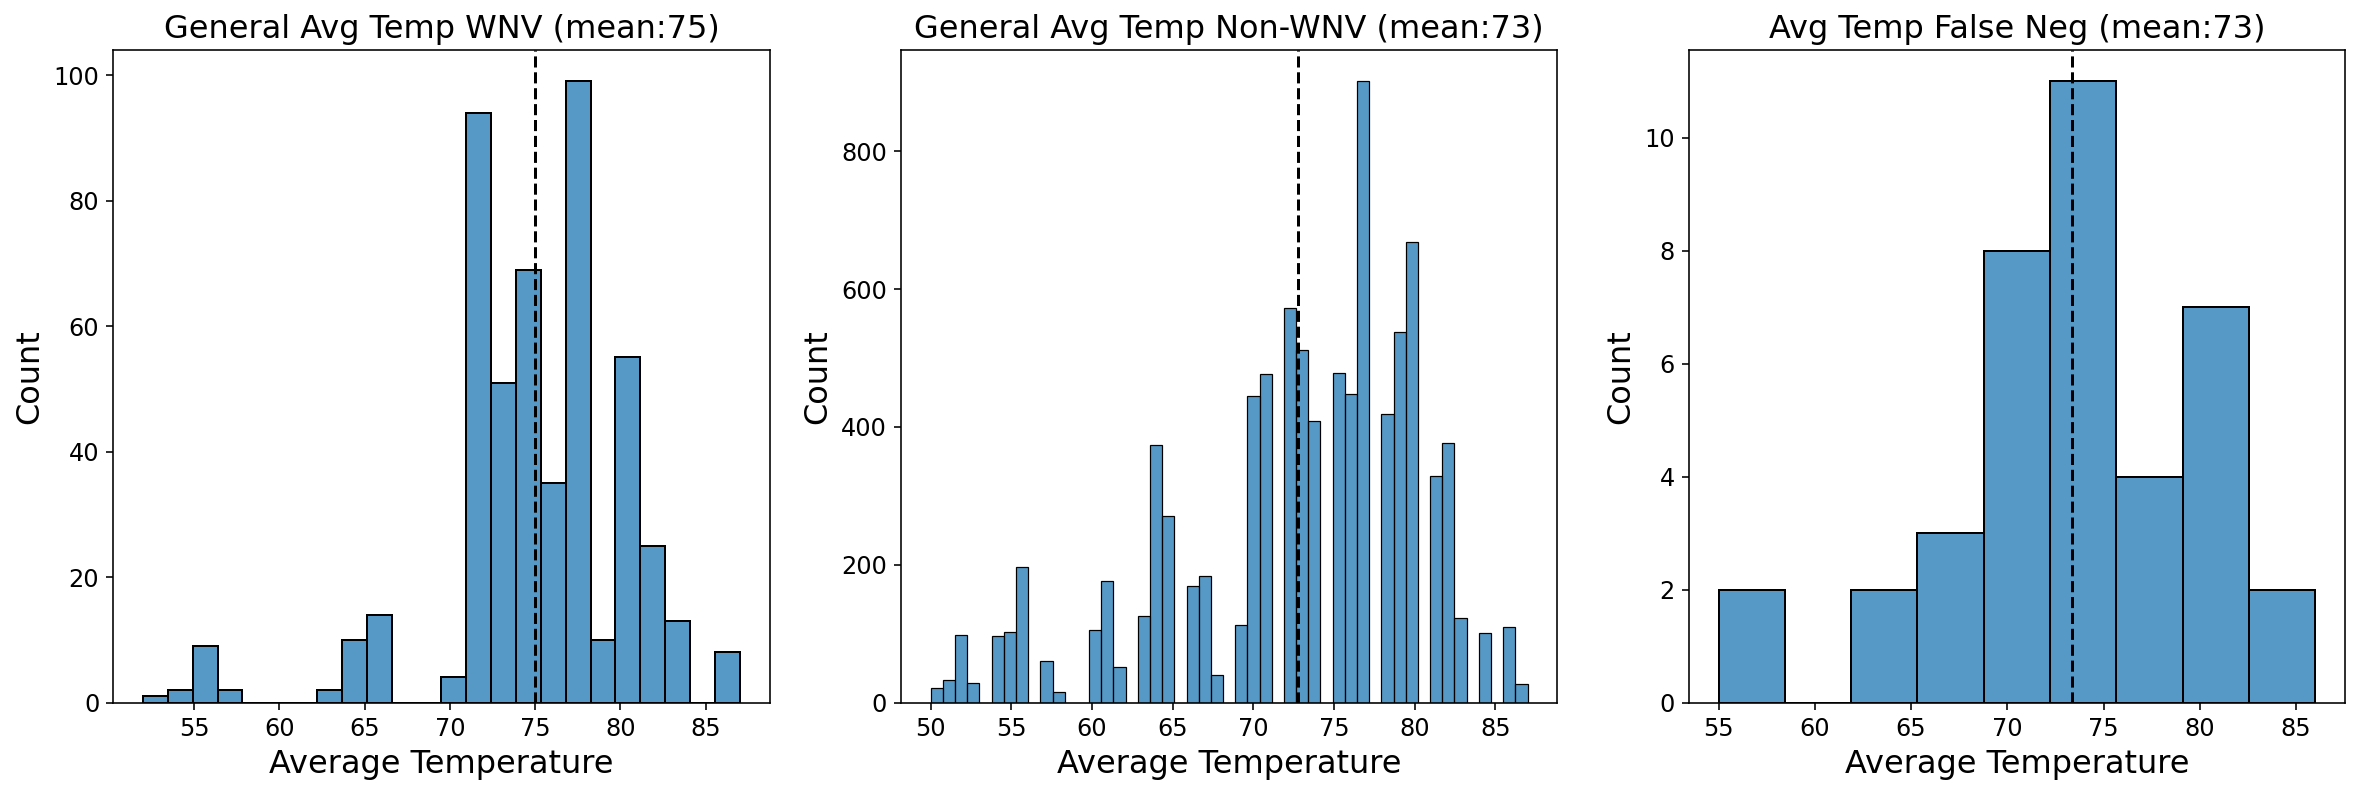

In [308]:
#Plotting out Average Temperature for general wnv, non-wnv and false neg
fig, ax = plt.subplots(1, 3, figsize = (20,6))

ax = ax.ravel()

sns.histplot(weather_train_df[weather_train_df['wnvpresent']==1]['tavg'],ax=ax[0])
ax[0].axvline(weather_train_df[weather_train_df['wnvpresent']==1]['tavg'].mean(), c = 'black', ls = '--')

sns.histplot(weather_train_df[weather_train_df['wnvpresent']==0]['tavg'],ax=ax[1])
ax[1].axvline(weather_train_df[weather_train_df['wnvpresent']==0]['tavg'].mean(), c = 'black', ls = '--')

sns.histplot(false_neg_df['tavg'],ax = ax[2])
ax[2].axvline(false_neg_df['tavg'].mean(), c = 'black', ls = '--')

ax[0].set_xlabel('Average Temperature',fontsize=16)
ax[1].set_xlabel('Average Temperature',fontsize=16)
ax[2].set_xlabel('Average Temperature',fontsize=16)
ax[0].set_ylabel('Count',fontsize=16)
ax[1].set_ylabel('Count',fontsize=16)
ax[2].set_ylabel('Count',fontsize=16)
ax[0].set_title(f'General Avg Temp WNV (mean:{round(weather_train_df[weather_train_df["wnvpresent"]==1]["tavg"].mean())})',fontsize=16)
ax[1].set_title(f'General Avg Temp Non-WNV (mean:{round(weather_train_df[weather_train_df["wnvpresent"]==0]["tavg"].mean())})',fontsize=16)
ax[2].set_title(f'Avg Temp False Neg (mean:{round(false_neg_df["tavg"].mean())})',fontsize=16)

We can see that in general, the average temperature for WNV cases is higher at 75. However, the mean for wrongly classified false negatives was similar to the general average temperature for Non-WNV cases which is 73. Hence, it is understandable that they were classified wrongly as they tend to have lower temperatures. 

Text(0.5, 1.0, 'Dewpoint False Neg (mean:59)')

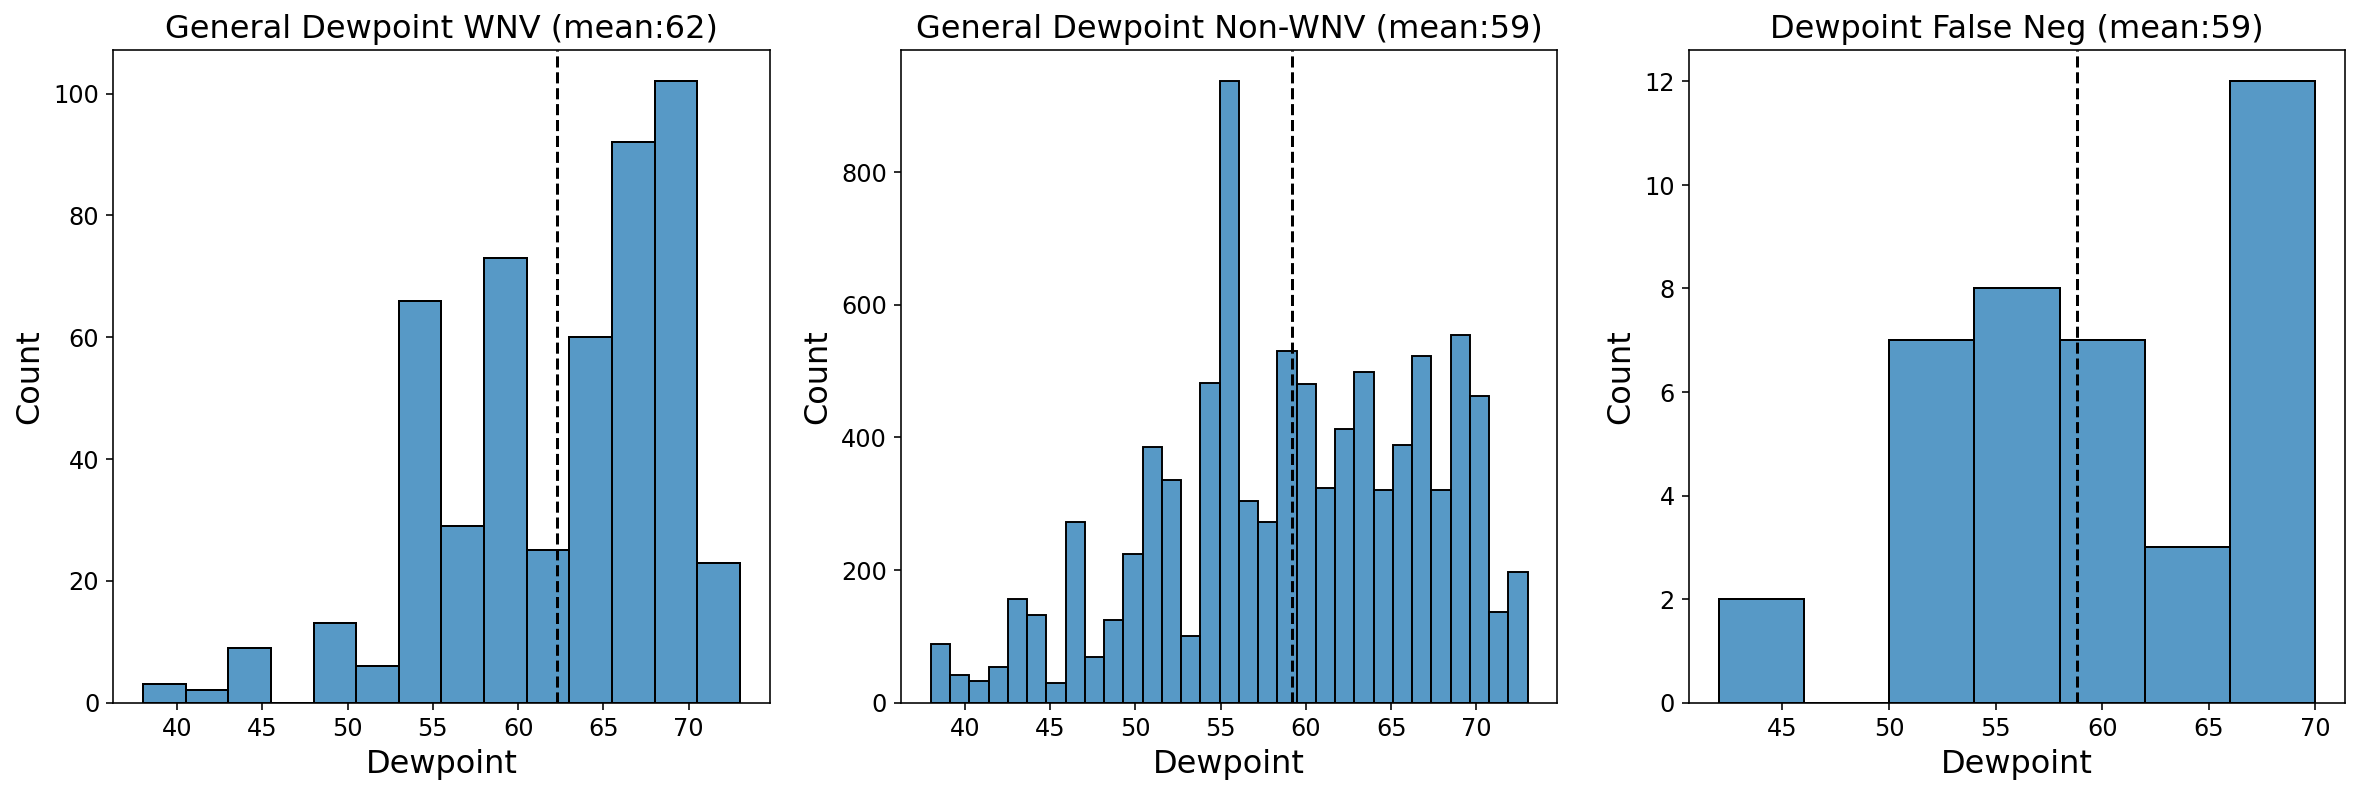

In [343]:
#Plotting out dewpoint for general wnv, non-wnv and false neg
fig, ax = plt.subplots(1, 3, figsize = (20,6))

ax = ax.ravel()

sns.histplot(weather_train_df[weather_train_df['wnvpresent']==1]['dewpoint'],ax=ax[0])
ax[0].axvline(weather_train_df[weather_train_df['wnvpresent']==1]['dewpoint'].mean(), c = 'black', ls = '--')

sns.histplot(weather_train_df[weather_train_df['wnvpresent']==0]['dewpoint'],ax=ax[1])
ax[1].axvline(weather_train_df[weather_train_df['wnvpresent']==0]['dewpoint'].mean(), c = 'black', ls = '--')

sns.histplot(false_neg_df['dewpoint'],ax = ax[2])
ax[2].axvline(false_neg_df['dewpoint'].mean(), c = 'black', ls = '--')

ax[0].set_xlabel('Dewpoint',fontsize=16)
ax[1].set_xlabel('Dewpoint',fontsize=16)
ax[2].set_xlabel('Dewpoint',fontsize=16)
ax[0].set_ylabel('Count',fontsize=16)
ax[1].set_ylabel('Count',fontsize=16)
ax[2].set_ylabel('Count',fontsize=16)
ax[0].set_title(f'General Dewpoint WNV (mean:{round(weather_train_df[weather_train_df["wnvpresent"]==1]["dewpoint"].mean())})',fontsize=16)
ax[1].set_title(f'General Dewpoint Non-WNV (mean:{round(weather_train_df[weather_train_df["wnvpresent"]==0]["dewpoint"].mean())})',fontsize=16)
ax[2].set_title(f'Dewpoint False Neg (mean:{round(false_neg_df["dewpoint"].mean())})',fontsize=16)

We can see that in general, the dewpoint for WNV cases is higher at 62. Similar to average temperature, the mean for wrongly classified false negatives was similar to the general dewpoint for Non-WNV cases which is 59. Hence, it is understandable that they were classified wrongly as they tend to have lower dewpoints.

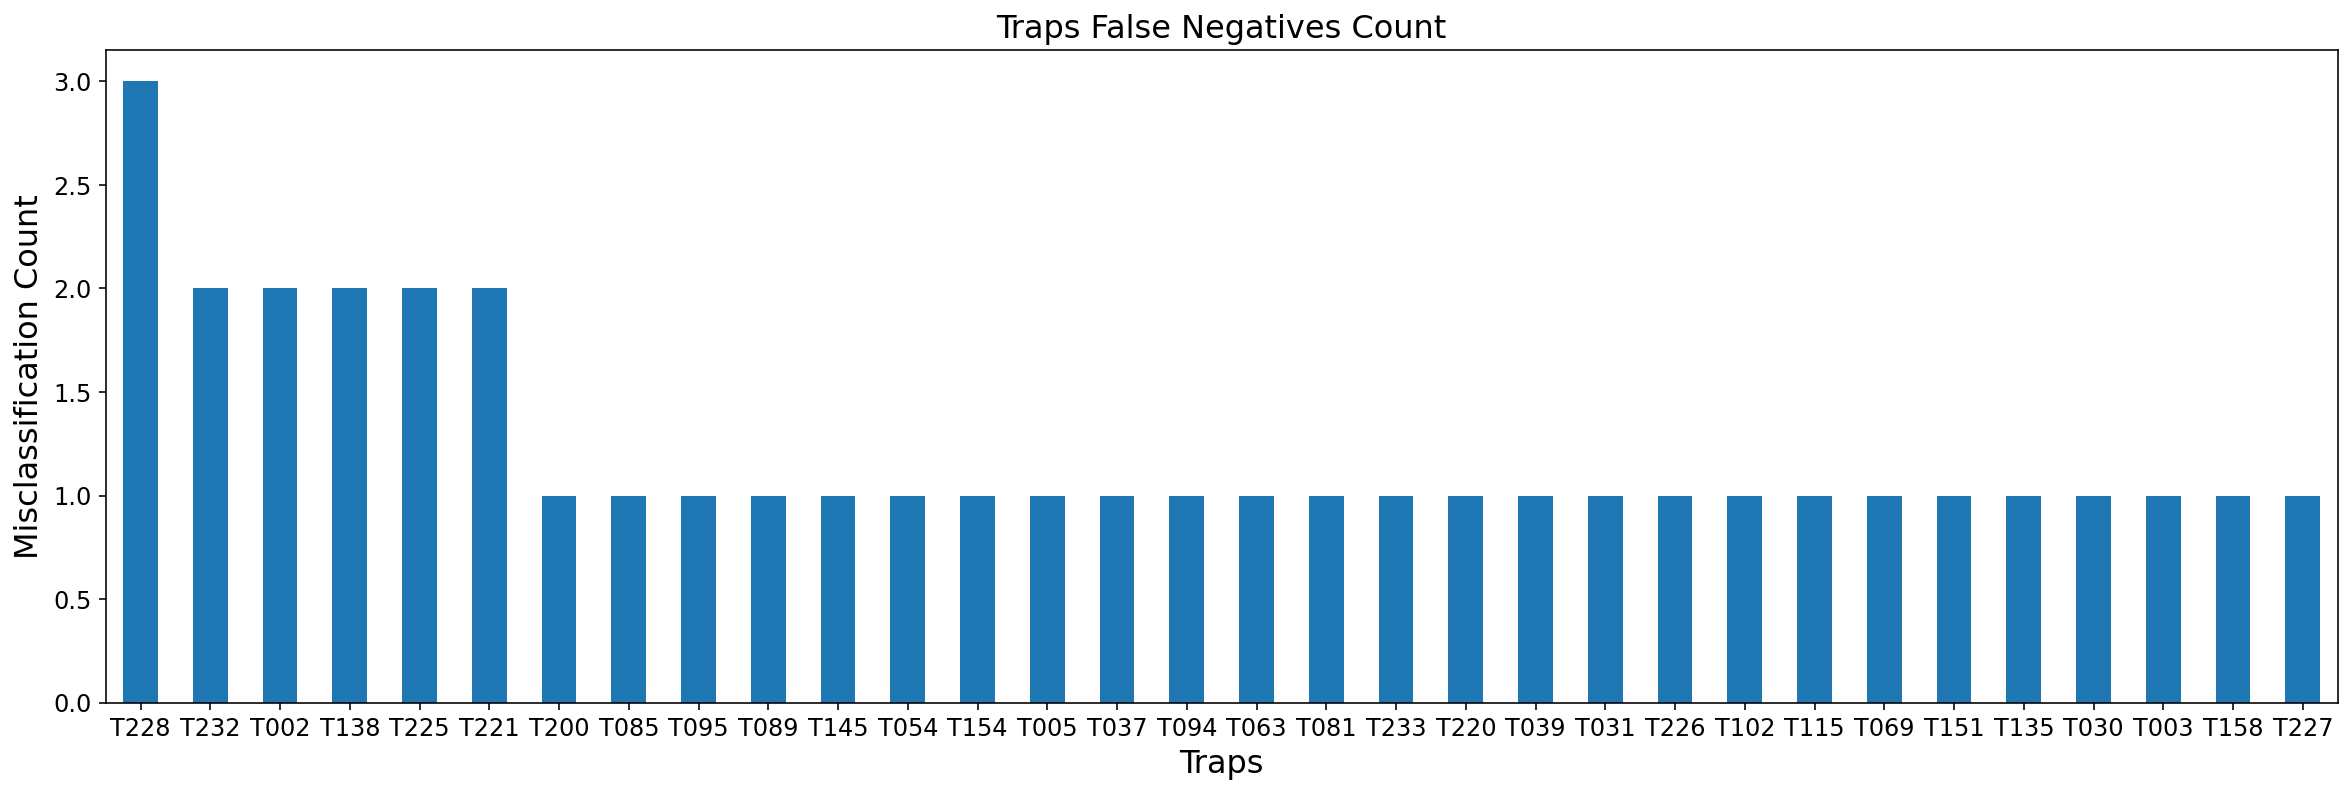

In [323]:
#plotting trap counts for each false negative trap
plt.figure(figsize=(20,6))
plt.title('Traps False Negatives Count',fontsize=16)
false_neg_df['trap'].value_counts().plot.bar()
plt.xlabel('Traps',fontsize=16)
plt.ylabel('Misclassification Count',fontsize=16)
plt.xticks(rotation = 360)
plt.show()

We can see that trap T228 has a higher count than the other traps being classified as false negative. It could be that the trap itself has a low wnv presence, and those 3 are the outliers that have wnv instance. Let us investigate this.

In [312]:
# display general percentage of wnv counts to compare

weather_train_df['wnvpresent'].value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

In [314]:
# identifying those with trap 228 and investigating wnv rate

weather_train_df[(weather_train_df['trap']=='T228')]['wnvpresent'].value_counts(normalize=True)

0    0.903226
1    0.096774
Name: wnvpresent, dtype: float64

Trap T228 has higher percentage of WNV present than general, which is suprising. Hence, our model should detect it. It should be other factors affecting it.
Hence, let us investigate those 3 cases further

In [315]:
# Sieving out index for t228 negative misclassifications

T228_index = false_neg_df[false_neg_df['trap']=='T228'].index

weather_train_df.loc[T228_index][['nummosquitos','month','tavg','dewpoint','trap']]

,nummosquitos,month,tavg,dewpoint,trap
7955,29,7,71.0,53,T228
4989,2,9,71.0,55,T228
8123,17,7,84.0,70,T228


On closer inspection of the outlier cases, it is likely that the low dewpoint, together with the months being in July and septermber (which have lower wnv count)
caused the model to mistakenly classify it as negative.

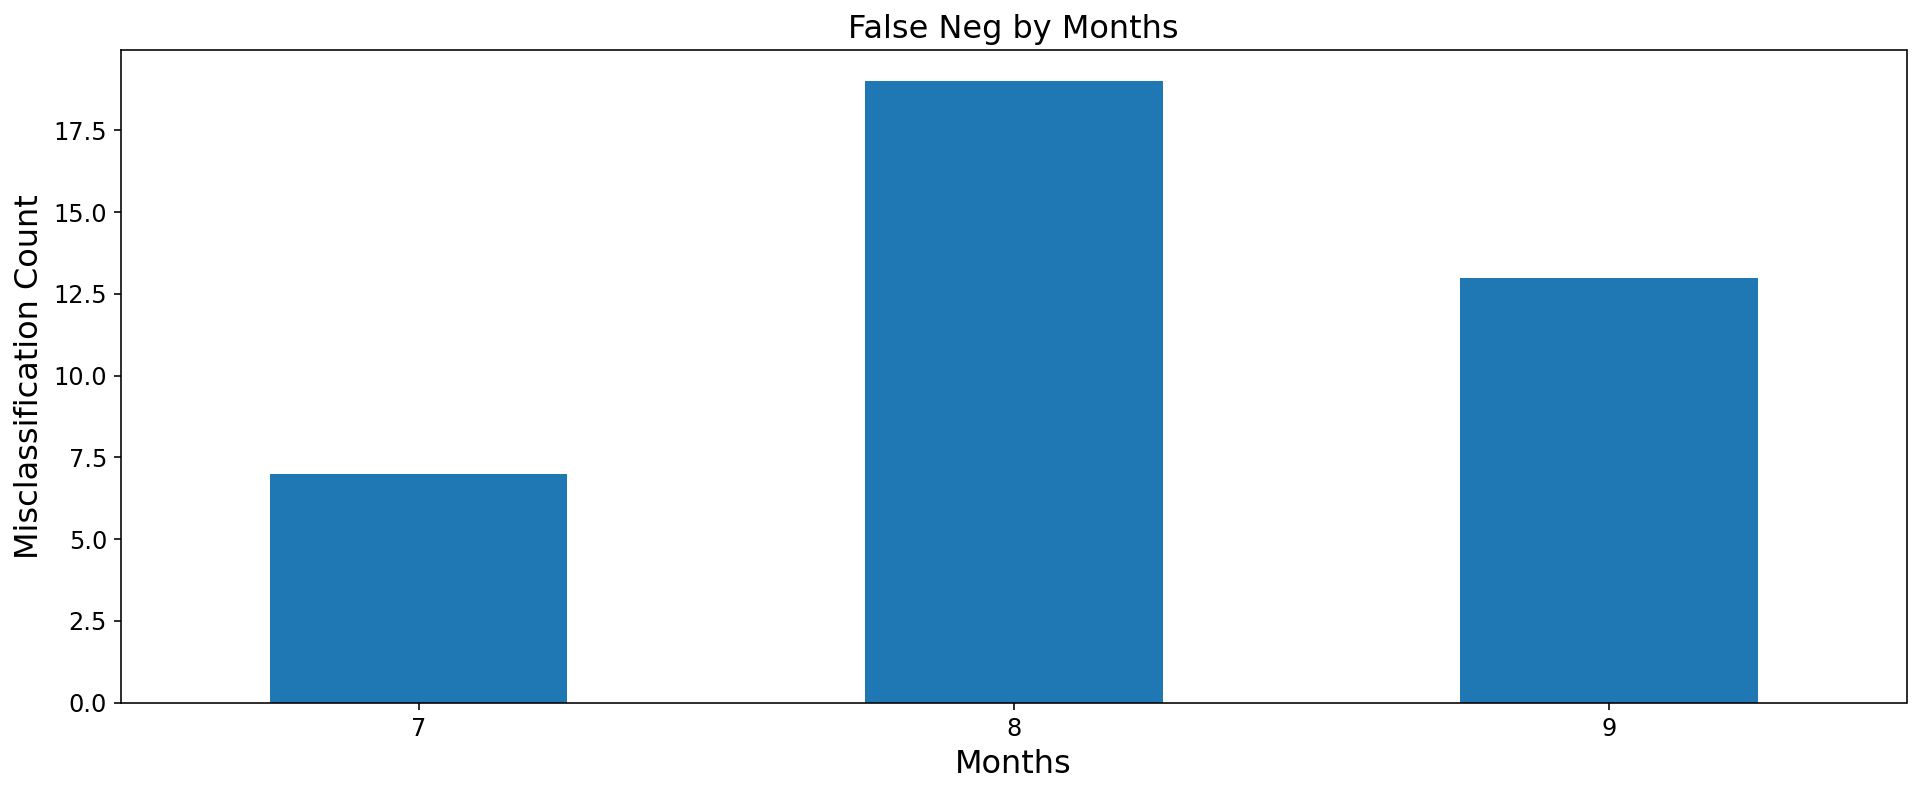

In [327]:
#Plotting false negative misclassifications by month
plt.figure(figsize=(16,6))
plt.title('False Neg by Months',fontsize=16)
plt.xlabel('Months',fontsize=16)
plt.ylabel('Misclassification Count',fontsize=16)
false_neg_df['month'].value_counts().sort_index().plot.bar()
plt.xticks(rotation = 360)
plt.show()

In [319]:
# counting samples by month
weather_train_df['month'].value_counts()

8     3308
7     2427
9     2112
6     1487
10     276
5       83
Name: month, dtype: int64

It is surprising that the model did not classify the months in august as wnvpresent. This is likely because there are too many samples in august, as shown above, thus leading to a higher count of misclassifications. It is however understandable that the model classified the months of july and september wrongly as the WNV in those months are less.

Text(0.5, 1.0, 'Avg False Neg Mosquitoes count (mean:14)')

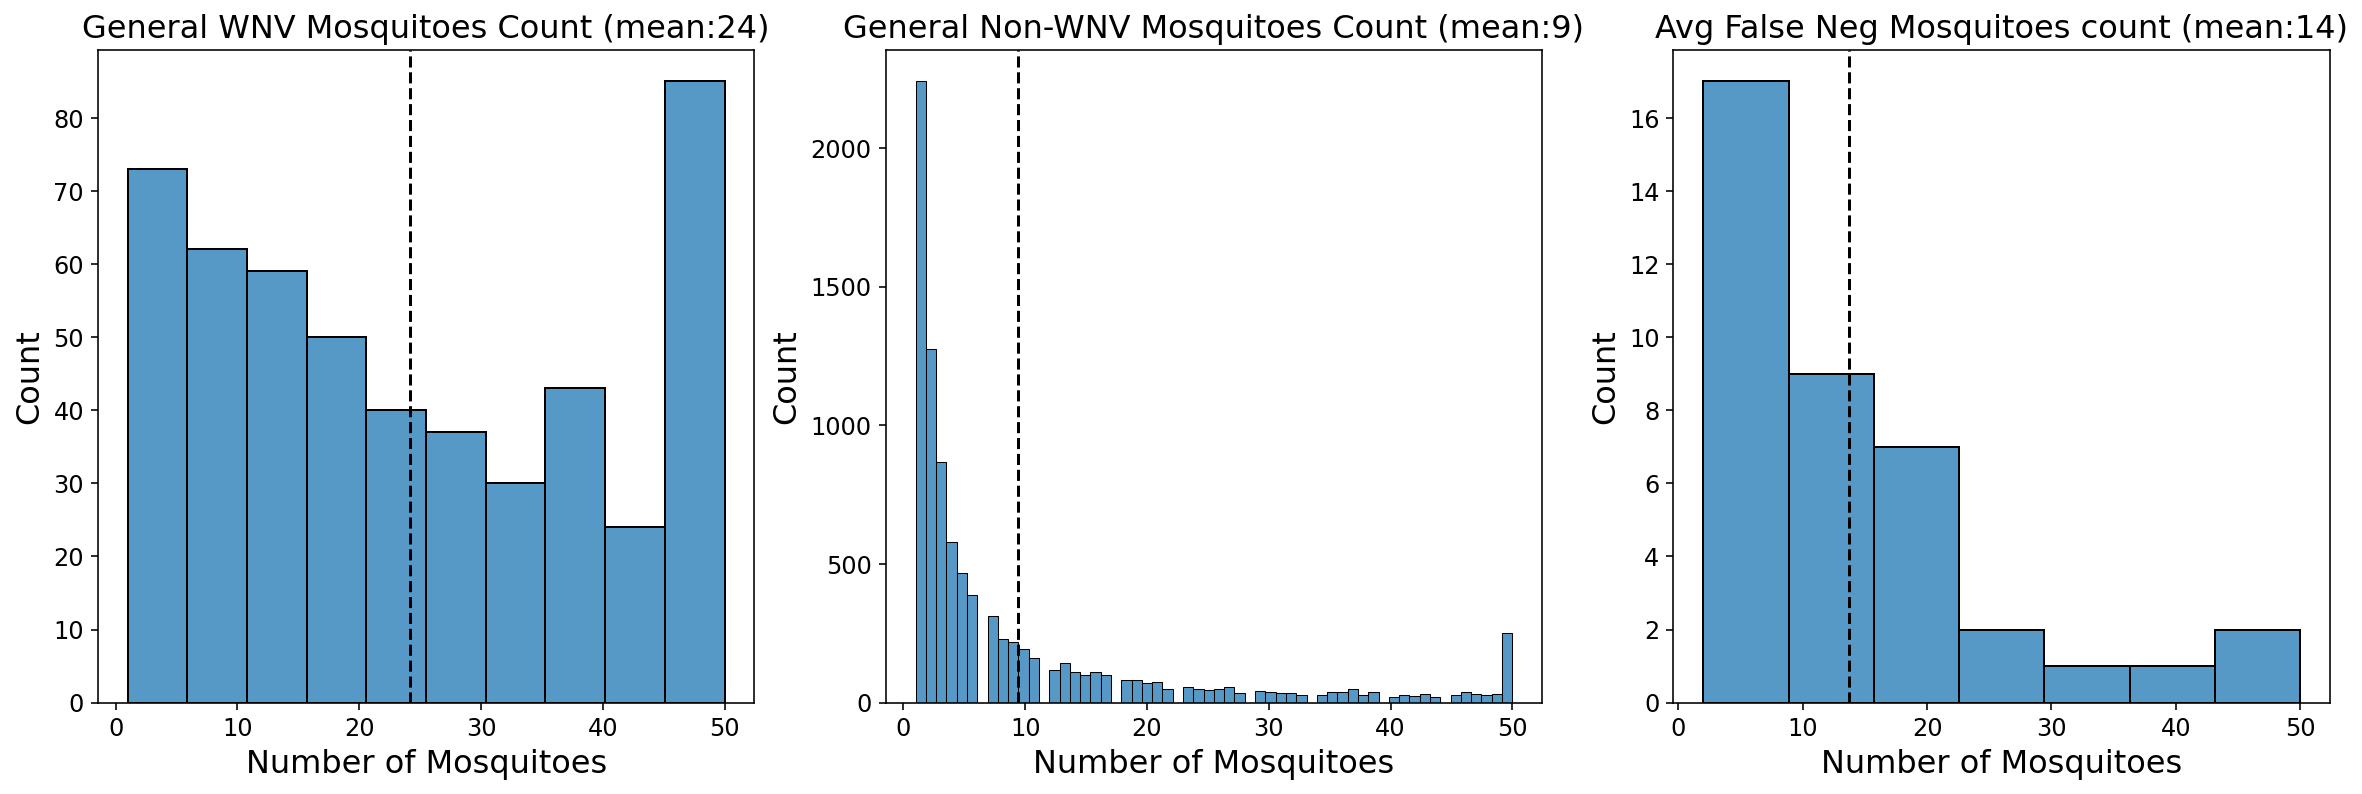

In [329]:
#Plotting out number of mosquitoes for general wnv, non-wnv and false neg
fig, ax = plt.subplots(1, 3, figsize = (20,6))

ax = ax.ravel()

sns.histplot(weather_train_df[weather_train_df['wnvpresent']==1]['nummosquitos'],ax=ax[0])
ax[0].axvline(weather_train_df[weather_train_df['wnvpresent']==1]['nummosquitos'].mean(), c = 'black', ls = '--')

sns.histplot(weather_train_df[weather_train_df['wnvpresent']==0]['nummosquitos'],ax=ax[1])
ax[1].axvline(weather_train_df[weather_train_df['wnvpresent']==0]['nummosquitos'].mean(), c = 'black', ls = '--')

sns.histplot(false_neg_df['nummosquitos'],ax = ax[2])
ax[2].axvline(false_neg_df['nummosquitos'].mean(), c = 'black', ls = '--')

ax[0].set_xlabel('Number of Mosquitoes',fontsize=16)
ax[1].set_xlabel('Number of Mosquitoes',fontsize=16)
ax[2].set_xlabel('Number of Mosquitoes',fontsize=16)
ax[0].set_ylabel('Count',fontsize=16)
ax[1].set_ylabel('Count',fontsize=16)
ax[2].set_ylabel('Count',fontsize=16)
ax[0].set_title(f'General WNV Mosquitoes Count (mean:{round(weather_train_df[weather_train_df["wnvpresent"]==1]["nummosquitos"].mean())})',fontsize=16)
ax[1].set_title(f'General Non-WNV Mosquitoes Count (mean:{round(weather_train_df[weather_train_df["wnvpresent"]==0]["nummosquitos"].mean())})',fontsize=16)
ax[2].set_title(f'Avg False Neg Mosquitoes count (mean:{round(false_neg_df["nummosquitos"].mean())})',fontsize=16)

We can see that the general Non-WNV mosquito count had a low mean of 9 as compared to 24 for WNV present cases. The model thus did quite well in this respect, where most of the negative misclassifications were indeed of lower number of mosquitoes, and hence it is understandable that the model would predict them as having no WNV. Next, we will move on to Cost Benefit Analysis.

## Cost Benefit Analysis

We will now explore a reported study to get the estimated cost benefit analysis figures for spraying of insecticides to prevent WNV infections <sup> 2 </sup>. In 2005, there was an outbreak of West Nile Virus (WNV) disease in Sacramento County, California, with 163 human cases reported. The Sacramento-Yolo Mosquito and Vector Control District conducted an emergency aerial spray. The WNV disease in Sacramento County cost ≈ \\$2.28 million for medical treatment and patients’ productivity loss for both West Nile fever (WNF) and West Nile neuroinvasive disease (WNND), which is a type of infection from WNV. Vector control cost ≈ $701,790, including spray procedures and overtime hours. The total economic impact of WNV was \\$2.98 million.</sup>

Out of the 163 cases, there were 46 WNND cases and 117 WNF cases. Total WNND medical and productivity cost is $2,625,200, while the total cost for WNF cases is \\$136,900.

In [124]:
# Calculating total cost per case

total_cases_2005 = 163
total_cost_2005 = 2625200 + 136900
cost_per_case = round((total_cost_2005/total_cases_2005),-3)
print(f'The cost per case is an estimated ${cost_per_case:,}')

The cost per case is an estimated $17,000.0


Two researchers, Elnaiem et al. and Carney et al., examined the efficacy of the 2005 emergency aerial spray in Sacramento County, which used pyrethrins as the active ingredients to control adult mosquitoes. In both studies, an unsprayed area within the county was used as the control. They found that there was a decrease of 57.5% WNV-competent vector mosquitoes for the sprayed areas against the unsprayed areas.

### Emergency Vector Control Spray

The emergency spray comprised 1,157 additional overtime hours in SYMVCD for August 2005. These overtime hours cost ≈ \\$41,790. The emergency spray cost ≈ \\$660,000, with the total emergency aerial spray response to the WNV epidemic costing a total of $701,790. The spray uses aerial ultra-low–volume adulticiding over 2 areas in Sacramento County comprising ≈ 477 km2. Aerial spraying was conducted on 6 nights in early and mid-August. 

With these figures, we can claculate the estimated costs of spraying. Please see below for the spray areas which we have identified. We have decided to spray for both the top areas identified from our EDA, and also the areas which our model has identified as good identifiers for WNV presence. Moreover, from our EDA, we also identified that WNV was mainly present in the months of July, August and September. This is supported by published research in the Journal of Medical Entomology <sup> 3 </sup>. Hence, it would be beneficial to spray every week for those identified months.

In [125]:
#Calculate total cost per km^2

total_cost_2005 = 701790
num_spray_2005 = 6 
km_spray_2005 = 477

spraycost_per_km = total_cost_2005/num_spray_2005/km_spray_2005
round(spraycost_per_km,2)

245.21

In [126]:
def get_distance(lat1, lon1, lat2, lon2): 
    
    ''' Function to calculate kilometers from total grid size'''
    
    R = 6373.0
    
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1 
    dlat = lat2 - lat1

    temp = (  
         math.sin(dlat / 2) ** 2 
       + math.cos(lat1) 
       * math.cos(lat2) 
       * math.sin(dlon / 2) ** 2
    )
    
    C = (2 * math.atan2(math.sqrt(temp), math.sqrt(1 - temp)))

    distance = R * C
    
    return distance

In [127]:
#calculating total grid size

long = get_distance(41.6,-88, 42.1,-88)
latitude = get_distance(41.6,-88, 41.6,-87.5)
total_area = round(long*latitude)

# cut our total grid into 50 blocks to calculate cost per block

area_per_block = total_area/50
area_per_block

46.26

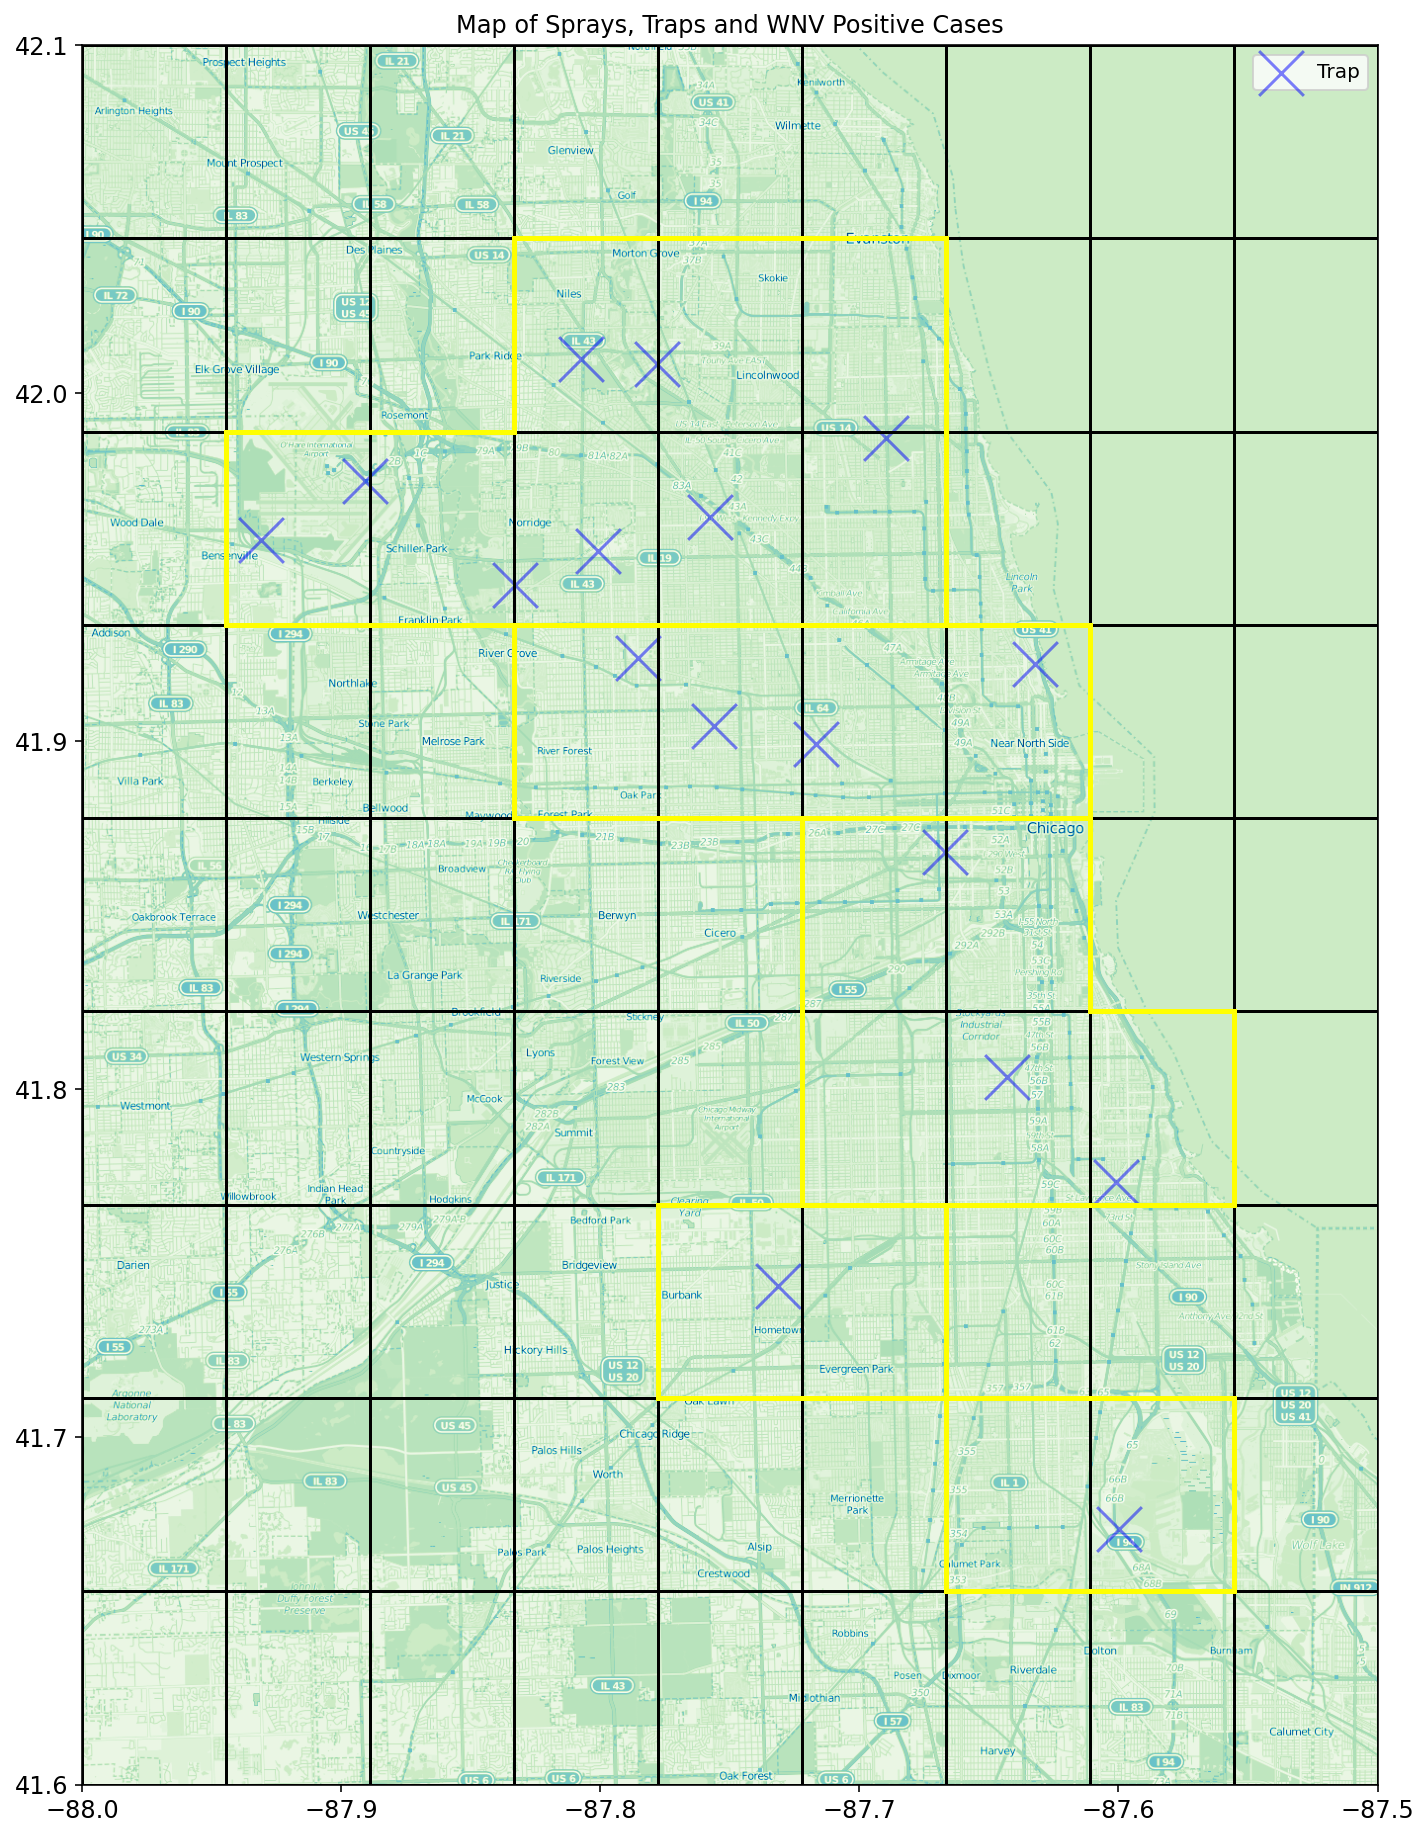

In [128]:
# Plotting out the top spray points

#spray = pd.read_csv('../data/spray_clean.csv')

mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)
plt.figure(figsize=(20,16))
plt.imshow(mapdata,
           cmap=plt.get_cmap('GnBu_r'),
           extent=lon_lat_box,
           aspect=aspect)

# top 10 traps from model that are good predictors of wnv
top_10_traps = log_coef[log_coef.index.str.contains('trap')].head(10)

traps_list = []

for i in pd.Series(top_10_traps.index.str.split('_')):
    traps_list.append(i[1])

# top 10 traps that have the most wnv cases from eda
top_10_traps_eda = ['T900','T030', 'T013', 'T002', 'T233', 'T225','T115', 'T054', 'T003', 'T008']

# Find the union of traps from both eda and model

traps_list_2 = set(top_10_traps_eda).union(set(traps_list))    
    
top_traps_df = weather_train_df[weather_train_df['trap'].isin(traps_list_2)][['date', 'trap','longitude', 'latitude', 'year','month','wnvpresent']]

trap_values = top_traps_df[['longitude', 'latitude']].drop_duplicates().values

#get spray data
# sprays = spray[spray['longitude']>-88]

# spray_values = sprays[['longitude', 'latitude']].drop_duplicates().values

# wnvpresent = top_traps_df[(top_traps_df['wnvpresent'] == 1)]
# wnvpresent_values = wnvpresent[['longitude', 'latitude']].drop_duplicates().values

# plotting of traps and sprays

# plt.scatter(spray_values[:,0], spray_values[:,1], c='orange', alpha=1, label="Spray")
plt.scatter(trap_values[:,0], trap_values[:,1], s = 500, c='blue',marker='x',label='Trap', alpha = 0.5)
#plt.scatter(wnvpresent_values[:,0], wnvpresent_values[:,1], s = 60, c='r', marker='o', label='wnv present mozzies')

# plotting gridlines to cut the grid into 50 blocks to identify areas

lat_lines = np.linspace(41.6,42.1,10)
long_lines = np.linspace(-88,-87.5,10)

for lat_line in lat_lines:
    plt.axhline(y=lat_line, color='black', linestyle='-')
    
for long_line in long_lines:
    plt.axvline(x=long_line, color='black', linestyle='-')

    
def plot_lines(long_1,lat_1,long_2,lat_2):
    
    ''' Function to plot lines to demarcate spray areas'''
    
    point1 = [long_lines[long_1],lat_lines[lat_1]]
    point2 = [long_lines[long_2],lat_lines[lat_2]]

    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]

    plt.plot(x_values, y_values,color='yellow', lw = 2.5)

plot_lines(1,6,5,6)
plot_lines(1,7,1,6)
plot_lines(1,7,3,7)
plot_lines(3,7,3,8)
plot_lines(6,6,6,8)
plot_lines(3,8,6,8)
plot_lines(3,8,5,8)
plot_lines(3,8,5,8)
plot_lines(3,8,5,8)
plot_lines(3,8,5,8)
plot_lines(3,5,7,5)
plot_lines(3,6,7,6)
plot_lines(3,5,3,6)
plot_lines(7,5,7,6)
plot_lines(5,4,5,5)
plot_lines(7,4,7,5)
plot_lines(5,3,5,4)
plot_lines(5,3,8,3)
plot_lines(8,4,8,3)
plot_lines(8,4,8,3)
plot_lines(7,4,8,4)
plot_lines(4,3,6,3)
plot_lines(6,3,6,2)
plot_lines(4,2,6,2)
plot_lines(4,3,4,2)
plot_lines(4,3,6,3)
plot_lines(6,3,6,2)
plot_lines(4,2,6,2)
plot_lines(4,3,4,2)
plot_lines(6,2,8,2)
plot_lines(8,2,8,1)
plot_lines(6,1,8,1)
plot_lines(6,2,6,1)

plt.title('Map of Sprays, Traps and WNV Positive Cases')
plt.legend();

We have highlighted the areas recommended from spraying demarcated by the yellow lines. These are areas which our model have identified as being good predictors for West Nile Virus, as well as areas identified from our EDA where there is high presence of WNV. It is worth noting that many of the detected locations are near the lake of michigan, which is understandable as humidity and water tends to increase mosquito breeding.

In [129]:
#calculating total cost per block

total_cost_per_block = area_per_block*spraycost_per_km
total_cost_per_block

#calculating total cost

spray_blocks = 21

spray_freq = 12

total_spray_cost = round(total_cost_per_block * spray_blocks * spray_freq)

total_spray_cost

2858536

Now that we have our total cost, we will have to compare against the benefits that can be obtained from spraying. To do this, we will identify the incidences of west nile virus from our identified spray locations from the year of our latest data (2013).

In [132]:
# Identifying incidences of west nile virus

top_traps_to_spray = top_traps_df[(top_traps_df['year']==2013) & ((top_traps_df['month']==7)|(top_traps_df['month']==8)|(top_traps_df['month']==9))]

top_traps_to_spray['wnvpresent'].value_counts()

0    496
1    116
Name: wnvpresent, dtype: int64

As it has proven that spraying can reduce WNV presence by 57.5%, we can estimate the decrease in WNV cases through spraying those areas.

In [133]:
# Calculating the estimated number of WNV incidences reduction after spray
estimated_wnv_reduction = top_traps_to_spray['wnvpresent'].value_counts()[1]*0.575
estimated_wnv_reduction

66.69999999999999

With the estimated figures of reduced WNV after spraying, we can now calculate the benefits of spraying. 

In [136]:
# Estimating reduced cost
# Assuming number of humans infected per wnv mosquito case is 3 

human_cases_per_wnv_case = 3

total_cost_savings = estimated_wnv_reduction * cost_per_case * human_cases_per_wnv_case - total_spray_cost

print(f'Cost savings assuming 3 human infections per WNV incident detected: ${total_cost_savings:,}')

# Estimated cost savings per additional case of human infection if exceed 3 infections for all incidences

total_cost_savings_per_add_case = estimated_wnv_reduction * cost_per_case

print(f'Cost savings per additional human infection per WNV incident detected: ${total_cost_savings_per_add_case:,}')

Cost savings assuming 3 human infections per WNV incident detected: $543,163.9999999991
Cost savings per additional human infection per WNV incident detected: $1,133,899.9999999998


We can see that if each case of WNV incident infects as little as 3 people, the city would have achieved cost savings of $863k. For each additional human infection per WNV incidence, the city would save an additional \\$1,104,575. That is to say if each WNV incidence would cause 4 human infections, the city would save an additional \\$1,104,575. Hence, it is highly recommended for the city to spray in the areas identified from July-September.

**Summary of costs illustrated on 2013 dataset:**

|Item|Cost|
|---|---|
|Spray cost for 6 weeks|\\$ 2,858,536|
|Total cost savings for 3 human infections per WNV incidence|\\$ 543,163|
|Cost saving per additional human infection after 3 infections|\\$ 1,133,900|

Our analysis may underestimate the actual cost of the WNV outbreak. Pain and distress are difficult to estimate monetarily but probably are important factors in the comprehensive costs of WNV disease. Additionally, we did not incorporate the benefits to the human population of reducing the nuisance of mosquito bites, irrespective of WNV transmission. In addition, the actual number of persons affected with WNF remains unknown because the total number of WNF cases probably was underreported and underdiagnosed.

### External Research

1. https://academic.oup.com/jme/article/56/6/1456/5572378

- Learnt about the healthcare issues arising from WNV.

2. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/

- Reference for case study to calculate associated costs of WNV

3. https://academic.oup.com/jme/article/56/6/1456/5572378

- Learnt about the worst time periods for WNV